# Project 
## Detect pneumonia in chest X-ray images

#### Reppas Dimitris - dhmhtrhsreppas@gmail.com
$$
$$



## Intro
In the scope of this project, we are to develop an intelligent system that detects pneumonia in chest X-ray images, but first, what is Pneumonia?

Pneumonia is an acute disease that is marked by inflammation of lung tissue accompanied by infiltration of alveoli and often bronchioles with white blood cells (such as neutrophils) and fibrinous exudate. It is characterized by fever, chills, cough, difficulty in breathing, fatigue, chest pain, and reduced lung expansion. The severity of the condition is variable. It is typically caused by an infectious agent (such as a bacterium, virus, or fungus) but identifying the responsible pathogen can be difficult. Diagnosis is often based on symptoms and physical examination. Chest X-rays, blood tests, and culture of the sputum may help confirm the diagnosis.

We will try to automate the diagnosis by developing the aforementioned system. It will be trained on a dataset of X-ray images, provided to us in https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia link. 

The first step is to analyse the provided dataset. From its structure, we can distinguish 3 folders (test, valid and train) and each one of them contains two subfolders (Pneumonia and Normal):

&emsp;chest_Xray/<br>
&emsp;&emsp;&emsp;test/<br>
&emsp;&emsp;&emsp;&emsp;&emsp;PNEUMONIA/<br>
&emsp;&emsp;&emsp;&emsp;&emsp;NORMAL/<br>
&emsp;&emsp;&emsp;valid/<br>
&emsp;&emsp;&emsp;&emsp;&emsp;PNEUMONIA/<br>
&emsp;&emsp;&emsp;&emsp;&emsp;NORMAL/<br>
&emsp;&emsp;&emsp;train/<br>
&emsp;&emsp;&emsp;&emsp;&emsp;PNEUMONIA/<br>
&emsp;&emsp;&emsp;&emsp;&emsp;NORMAL

The **test** folder contains the data we will use to test our system once it has been trained.<br>
The **valid** folder contains the data we will use to validate and finetune our system during training. This data will help us to prevent our system from 'Overfitting'. This subset is about to be used only for deeper architectures and not for the classic ones.<br>
Lastly, the **train** folder contains the data we will use to train our system.<br>
By inspecting the filenames in Pneumonia folders, it is observed that there are images from 2 pathogens: Bacteria(eg person1_bacteria_1.jpeg) and Virus(eg person1180_virus_2012.jpeg).

Considering the above one could create a multiclass classifier (Normal,Pneumonia_bacteria,Pneumonia_virus) instead of a binary one (Normal,Pneumonia). However, in our experiments, we decided to train the classification algorithms based on the two main classes: Pneumonia and Normal. Therefore, the algorithms will learn to categorize a given image in one of the two main classes.

In [9]:
import cv2
import glob
import numpy as np
import random as rn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import keras
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn import svm
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE 

In [10]:
path = './'



# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'


# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')



# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])


# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

Now that we have parsed the dataset into three lists (train, test and validation based on dataset structure) and shuffled the contents of each list, we are going to visualize the distribution of normal and pneumonia cases in each one of them.

"Why do we need to do that" you may ask. Visualizing the distribution of our data is crucial as we need to know if our data is balanced or imbalanced, as well as if we have enough for our cause. The more data we have, the better our system will be trained/tested (this fact is crucial especially for deeper architectures), however, quantity only is not enough. Quality is important too. We need our dataset to be balanced which means to have the same or similar amount of data for each class in the dataset. Why? Let's say that in our train dataset, 1/5 is normal cases and 4/5 are pneumonia cases. By using such datasets in the training procedure, 'biased' models are produced. In other words, an imbalanced data-set will bias the prediction model towards the more common class. 

Let's take a look at the provided dataset.

In [124]:
data_train = train_df['label'].value_counts()
normal_train = data_train[0]
pneumonia_train = data_train[1]
total_train = normal_train + pneumonia_train 

data_valid = val_df['label'].value_counts() # Count the number of each class in validation set
normal_valid = data_valid[0]
pneumonia_valid = data_valid[1]
total_valid = normal_valid + pneumonia_valid 

data_test = test_df['label'].value_counts()
normal_test = data_test[0]
pneumonia_test = data_test[1]
total_test = normal_test + pneumonia_test

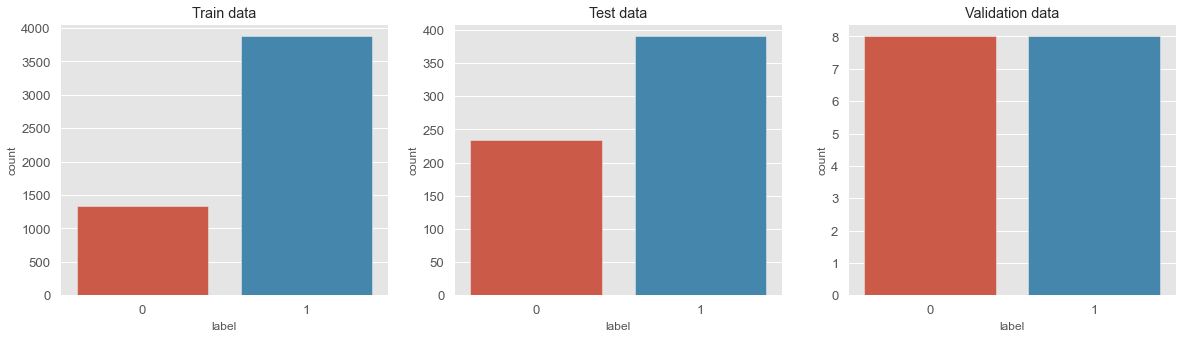

In [125]:
plt.figure(figsize=(20,5))
plt.style.use('ggplot')

plt.subplot(1,3,1)
sns.countplot(train_df['label'])
plt.title('Train data')

plt.subplot(1,3,2)
sns.countplot(test_df['label'])
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(val_df['label'])
plt.title('Validation data')

plt.show()

From the previous count plots,we observe that for each dataset (training, validation and testing) there is variation in the balance between the two categories:
- The training dataset is highly imbalanced. The ratio of normal to pneumonia cases is almost 1:3!,
- The validation dataset is balanced but too small, and,
- The testing dataset is also imbalanced.

We will fix the issues of imbalance and small dataset in a while. Before that, let's see some cases of pneumonia and some cases of healthy people.

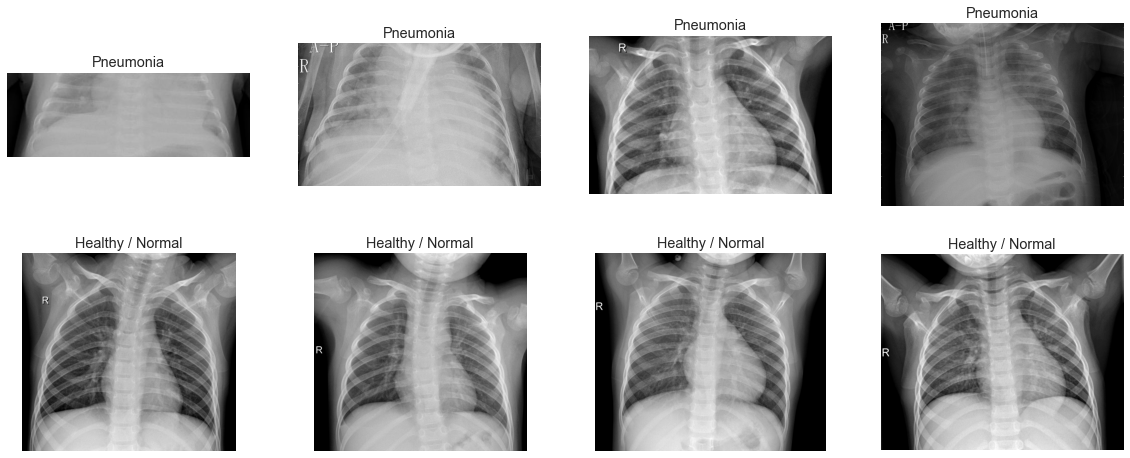

In [126]:
plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_df[train_df['label'] == 1][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')
    
for i,img_path in enumerate(train_df[train_df['label'] == 0][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Healthy / Normal')

There is no doubt, that differentiating between a normal and a pneumonia case when you don't have the appropriate skills is not trivial. We certainly couldn't identify correctly most of the images above, however, we do observe that not all images have the same dimensions! This is an issue we will address by reshaping the images.

### Data preprocessing

As mentioned above, there are two issues we need to address:
1) Different image dimensions<br>
2) Imbalanced and small datasets

As far as it concerns the first issue, we are going to resize all the images to 127x127 pixels, because the smallest image dimension in the dataset is 127 pixels. We also observed that some images are in grayscale while the majority of them are in RGB. We decided to convert all images from all datasets(training, validation, testing) to grayscale and normalize their values so that they range from [0,1].

To make the following code simple and easy to read, we define 2 functions that will help us with the resizing and grayscale conversion:
- **convert_to_grayscale_and_resize_data**: this function loads an image, resizes it to 127x127 pixels, converts to grayscale, normalizes its values and reshapes the image.
- **compose_dataset**: this function receives dataframes and generates 2 numpy arrays, the first contains the images and the second contains their labels.

In [127]:
def convert_to_grayscale_and_resize_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (127, 127))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (127,127,1))
    
    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(convert_to_grayscale_and_resize_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

In [128]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 127, 127, 1), Labels shape: (5216,)
Test data shape: (624, 127, 127, 1), Labels shape: (624,)
Validation data shape: (16, 127, 127, 1), Labels shape: (16,)


Now that we have all our images resized to 127x127 pixels, we will get some desctriptive statistics of each class per dataset and compare the results. We separate the normal from pneumonia classes per dataset and then use the **describe** method of pandas.DataFrame package to get basic statistical details like mean, std etc. of a data frame.

In [131]:
normal_hist_train = pd.DataFrame(X_train[y_train==0].flatten())
pneumonia_hist_train = pd.DataFrame(X_train[y_train==1].flatten())

normal_hist_valid = pd.DataFrame(X_val[y_val==0].flatten())
pneumonia_hist_valid = pd.DataFrame(X_val[y_val==1].flatten())

normal_hist_test = pd.DataFrame(X_test[y_test==0].flatten())
pneumonia_hist_test = pd.DataFrame(X_test[y_test==1].flatten())

In [132]:
# Definition of train description dataframe
descr_normal_hist_train = normal_hist_train.describe()
descr_pneumonia_hist_train = pneumonia_hist_train.describe()

# Definition of valid description dataframe
descr_normal_hist_valid = normal_hist_valid.describe()
descr_pneumonia_hist_valid = pneumonia_hist_valid.describe()

# Definition of test description dataframe
descr_normal_hist_test = normal_hist_test.describe()
descr_pneumonia_hist_test = pneumonia_hist_test.describe()

In [133]:
print('Some descriptive statistics for \033[1m\033[95mNormal\033[0m class and \033[1m\033[95mTraining\033[0m set are', descr_normal_hist_train)
print(117*'=')
print('Some descriptive statistics for \033[1m\033[95mPneumonia\033[0m class and \033[1m\033[95mTraining\033[0m set are', descr_pneumonia_hist_train)
print(117*'=')
print('Some descriptive statistics for \033[1m\033[36mNormal\033[0m class and \033[1m\033[36mValidation\033[0m set are', descr_normal_hist_valid)
print(117*'=')
print('Some descriptive statistics for \033[1m\033[36mPneumonia\033[0m class and \033[1m\033[36mValidation\033[0m set are', descr_pneumonia_hist_valid)
print(117*'=')
print('Some descriptive statistics for \033[1m\033[93mNormal\033[0m class and \033[1m\033[93mTest\033[0m set are', descr_normal_hist_test)
print(117*'=')
print('Some descriptive statistics for \033[1m\033[93mPneumonia\033[0m class and \033[1m\033[93mTest\033[0m set are', descr_pneumonia_hist_test)
print(117*'=')

Some descriptive statistics for Normal class and Training set are                   0
count  2.162899e+07
mean   4.794404e-01
std    2.468716e-01
min    0.000000e+00
25%    3.176471e-01
50%    5.176471e-01
75%    6.745098e-01
max    1.000000e+00
Some descriptive statistics for Pneumonia class and Training set are                   0
count  6.249988e+07
mean   4.826699e-01
std    2.339494e-01
min    0.000000e+00
25%    3.137255e-01
50%    5.254902e-01
75%    6.745098e-01
max    1.000000e+00
Some descriptive statistics for Normal class and Validation set are                    0
count  129032.000000
mean        0.485002
std         0.269951
min         0.000000
25%         0.278431
50%         0.545098
75%         0.717647
max         1.000000
Some descriptive statistics for Pneumonia class and Validation set are                    0
count  129032.000000
mean        0.494077
std         0.241695
min         0.000000
25%         0.349020
50%         0.556863
75%         0.686275
max      

#### Results Summary
Let's have a look at the __count__ and __mean__ statistical details.

- **Training dataset**<br>
 - **normal class:** we have 2.162899e+07 pixels and mean 4.794404e-01<br>
 - **pneumonia class:** we have 6.249988e+07 pixels and mean 4.826699e-01<br>
 The Pneumonia class count being almost three times the Normal class count is expected. As mentioned earlier, the training dataset is imbalanced, with pneumonia cases size being almost thrice the data size of normal cases. What is more important here though is the mean! Mean value for normal cases is smaller than the pneumonia one. "So what? it's only a bit smaller" one may argue. Well yes the difference may not be much **but** what this difference indicates is that normal case images have more dark pixels than the pneumonia ones and it can be enough for an intelligent system to distinguish between normal and pneumonia cases. This difference in mean values may be due to vacteria and viruses appearing as white spots/highlighted areas in X-ray images.
 

- **Validation dataset**<br>
 - **normal class:** we have 129032 pixels and mean 0.485002<br>
 - **pneumonia class:** we have 129032 pixels and mean 0.494077<br>
 Here the count value for both classes is the same and much smaller than the ones of the training dataset. This verifies the earlier observation, that the validation dataset is balanced but small in size. Again, the mean value for normal cases is bit smaller that the pneumonia one.
 
 
- **Testing dataset**<br>
 - **normal class:** we have 3.774186e+06 pixels and mean 4.861496e-01<br>
 - **pneumonia class:** we have 6.290310e+06 pixels and mean 4.670730e-01<br>
 Like in training dataset, testing dataset is an imbalanced one, where there are more pneumonia cases than normal ones. In this case, if we take a look at the mean values, normal mean value is __greater__ than the pneumonia one! Considering the above,this fact sounds quite confusing, therefore further analysis must be held.

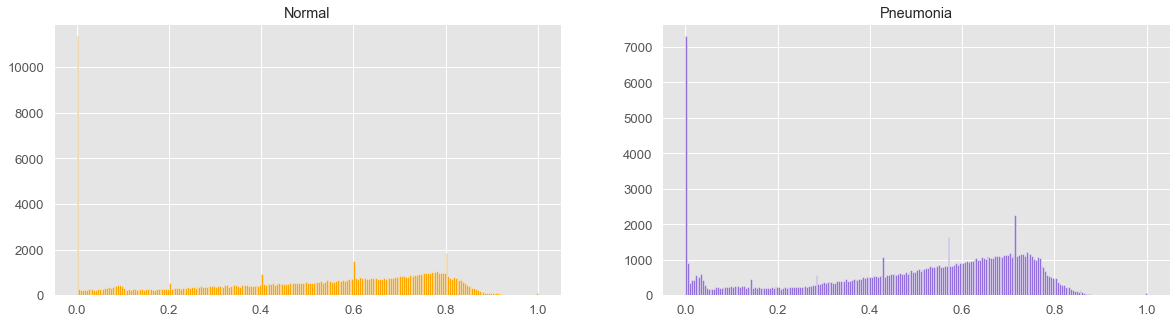

In [134]:
plt.figure(figsize=(20,5))
plt.style.use('ggplot')

normal_flat = normal_hist_valid.values.flatten()
normal_unique_values = np.unique(normal_flat, return_index=False, return_inverse=False, return_counts=True, axis=0)

plt.subplot(1,2,1)
plt.hist(normal_flat, bins=len(normal_unique_values[0]), color = "orange")
plt.title('Normal')

pneumonia_flat = pneumonia_hist_valid.values.flatten()
pneumonia_unique_values = np.unique(pneumonia_flat, return_index=False, return_inverse=False, return_counts=True, axis=0)

plt.subplot(1,2,2)
plt.hist(pneumonia_flat, bins=len(pneumonia_unique_values[0]), color = "mediumpurple")
plt.title('Pneumonia')

plt.show()

At this point of the Project, we will use Validation set and Histograms to analyze the pixels' distributions of each class. The Validation dataset is balanced and that makes it perfect to show that normal case images have more dark pixels/areas than the pneumonia ones. By observing the two histograms above and comparing them, we can see that in the normal case over 10k pixels have a value equal to 0, while in pneumonia cases only 6k pixels have a value of 0.

For further exploratory data analysis, we will use the training set this time, take a sample of 400 images of each category and calculate the median values for each category. After the calculation, we will plot and compare the two produced images and finally, a brief discussion of the results will take place. 


In [136]:
reshaped1 = X_train.reshape((X_train.shape[0], 127, 127))

In [137]:
reshaped2 = reshaped1.reshape((X_train.shape[0], 16129))

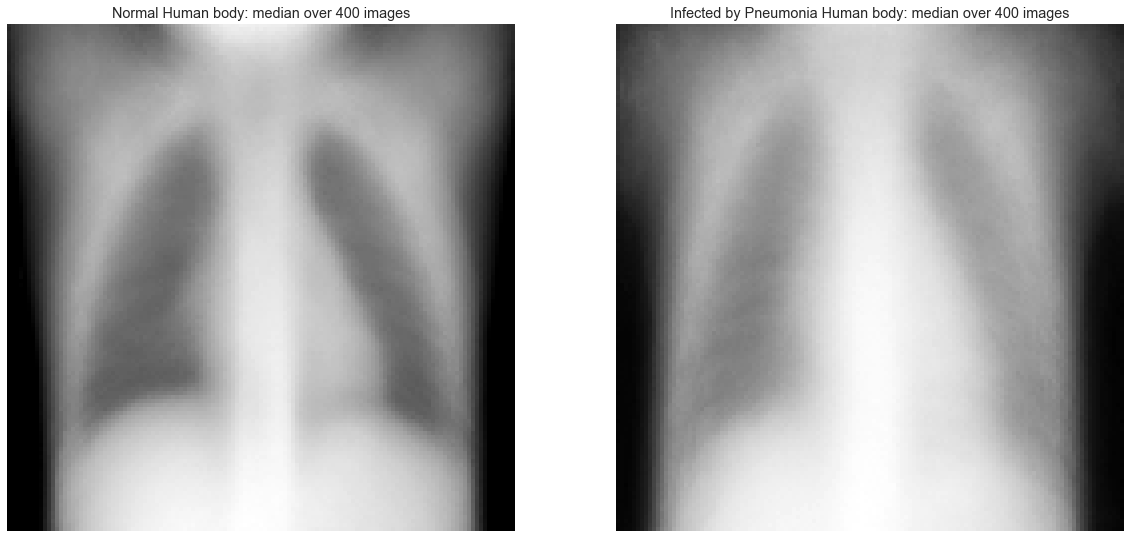

In [138]:
plt.rcParams["figure.figsize"] = (20,18)
ax = plt.subplot(1,2,1)
ax.imshow(pd.DataFrame(reshaped2[y_train==0]).sample(400).median().values.reshape(127,127), cmap='gray')
plt.title('Normal Human body: median over 400 images')
plt.axis("off")

ax2=plt.subplot(1,2,2)
ax2.imshow(pd.DataFrame(reshaped2[y_train==1]).sample(400).median().values.reshape(127,127), cmap='gray')
plt.title('Infected by Pneumonia Human body: median over 400 images')
plt.axis("off")

plt.show()

From the two images, it is observed that in the case of healthy people, we can see that the area around the heart is much darker and clearer than the corresponding area in pneumonia cases which seems to be lighter, more blurred and noisy.

Since we've finished with the data exploration analysis the next stage of the project contains the use of image classification techniques. First of all, Classic Machine Learning algorithms will be used and in the next stage, deeper architectures are employed as well. The evaluation of each method is held via Confusion matrixes, Classification reports on the test set, Inference Modules, Learning curves (used only in DNN)

## Classic Machine Learning approaches

Up to this point we have resolved the issue of different image dimensions by resizing them, and we are about to start training our system. For the Classic Machine Learning methods, we will use only the training and the testing datasets. Before we start though, we must resolve the issue of imbalance in training dataset. The most used approaches to overcome class imbalance is either by using less data from the class with the higher ratio (down sampling) or increasing the data of the class with the lower ratio (over sampling). As we mentioned before, when training a model, the greater number of data we have, the better scores we achieve, so our approach will be the one of over sampling. To achieve that we will use the SMOTE library from imblearn.over_sampling package.

In [139]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = y_train
Y_test = y_test
X_trainFlat.shape

(5216, 16129)

In [140]:
sm = SMOTE(random_state=42)
X_trainsm, Y_trainsm = sm.fit_resample(X_trainFlat, Y_train)

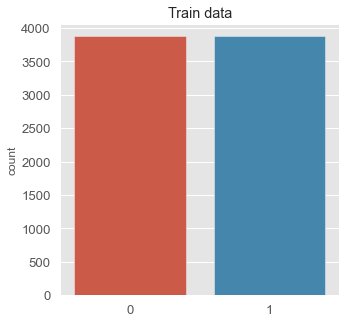

In [142]:
plt.figure(figsize=(5,5))
plt.style.use('ggplot')

plt.subplot(1,1,1)
sns.countplot(Y_trainsm)
plt.title('Train data')
plt.show()

Now that we have a balanced training dataset, we can begin the training process! We are going to use 3 algorithms:
- Random Forest Classifier, 
- Support Vector Classification and 
- Logistic Regression


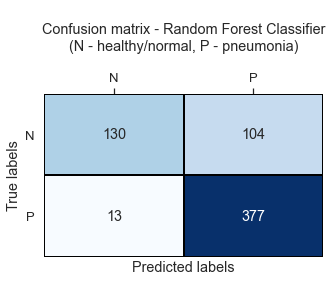


Classification report on test data

              precision    recall  f1-score   support

           0       0.91      0.56      0.69       234
           1       0.78      0.97      0.87       390

    accuracy                           0.81       624
   macro avg       0.85      0.76      0.78       624
weighted avg       0.83      0.81      0.80       624



In [143]:
RFC=RandomForestClassifier(max_depth=10,n_estimators=150) 
RFC.fit(X_trainsm,Y_trainsm)
ypredict = RFC.predict(X_testFlat)


cm = confusion_matrix(Y_test, ypredict)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, annot=True,xticklabels=['N', 'P'], yticklabels=['N', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('\nConfusion matrix - Random Forest Classifier\n(N - healthy/normal, P - pneumonia)\n')
plt.show()

# print classification report
print('\nClassification report on test data\n')
print(classification_report(Y_test,ypredict))

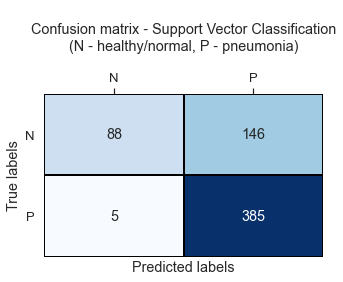


Classification report on test data

              precision    recall  f1-score   support

           0       0.95      0.38      0.54       234
           1       0.73      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.84      0.68      0.69       624
weighted avg       0.81      0.76      0.72       624



In [144]:
C = 1

SVC = svm.SVC(C=C, kernel='poly', degree=2, probability=True) 
SVC.fit(X_trainsm,Y_trainsm)

ypredict = SVC.predict(X_testFlat)

cm = confusion_matrix(Y_test, ypredict)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, annot=True,xticklabels=['N', 'P'], yticklabels=['N', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('\nConfusion matrix - Support Vector Classification\n(N - healthy/normal, P - pneumonia)\n')
plt.show()

# print classification report
print('\nClassification report on test data\n')
print(classification_report(Y_test,ypredict))

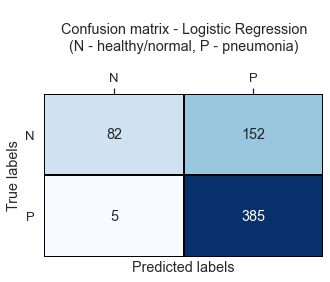


Classification report on test data

              precision    recall  f1-score   support

           0       0.94      0.35      0.51       234
           1       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.83      0.67      0.67       624
weighted avg       0.80      0.75      0.71       624



In [145]:
LR = LogisticRegression(random_state=0, max_iter=1000)
LR.fit(X_trainsm,Y_trainsm) 

ypredict = LR.predict(X_testFlat)

cm = confusion_matrix(Y_test, ypredict)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, annot=True,xticklabels=['N', 'P'], yticklabels=['N', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('\nConfusion matrix - Logistic Regression\n(N - healthy/normal, P - pneumonia)\n')
plt.show()

# print classification report
print('\nClassification report on test data\n')
print(classification_report(Y_test,ypredict))

### Discussion of the Resuls
By the comparison of the three methods, it is clear from the Confusion matrixes and the classification reports that in general, the Random Forest Classifier outperforms the other approaches. To be more specific:
1) As far as it concerns the classification reports Random Forest Classifier had the best accuracy, best f1-scores for both categories, the best precision for Pneumonia class, the best recall in the Normal category.<br>
2) From the confusion matrix, it is observed that the Normal category is predicted by far better from Random Forest Classifier, although its performance for the Pneumonia label is not the best.

The performances of the two other methods are really close in the metrics. If we had to choose which was the second best method, we would choose the Support Vector Machine classifier. Finally, the worst results were obtained by the Logistic Regression classifier  

### Inference module
In this section of the Project, one user is able to see for each image, that is part of the test set which was the predicted label from the model and which is the actual. Along with the previous information, it can obtained the confidence of the model in each choice (probability)! 

In [146]:
def analyse_model_prediction(data, true_labels, model, image_num, nb_class=2, ensemble_size=1):
    CLASS_LABELS = ['NORMAL', 'PNEUMONIA']    
    image = data[image_num]
    true_label = true_labels[image_num]
    predicted_probabilities = np.empty(shape=(ensemble_size, nb_class))
    model_prediction = model.predict_proba(image[np.newaxis, :])
    predicted_probabilities[:ensemble_size] = model.predict_proba(image.reshape(1, -1))
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})
    
    # Show the image and the true label
    ax1.imshow(image.reshape(127, 127), cmap='gray')
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(CLASS_LABELS[true_label]))
    
    # Show a 95% prediction interval of model predicted probabilities
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(nb_class)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 95) for i in range(nb_class)])    
    bar = ax2.bar(np.arange(nb_class), pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(nb_class), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(2))
    ax2.set_xticklabels(CLASS_LABELS)
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Model estimated probabilities')
    plt.show()

In this particular example, we use the best model so far (Random Forest Classifier) and the 3rd image of the test set (simply change the number, to observe other results). As we can see, the model is 76% confident for its choice which is predicted correctly 

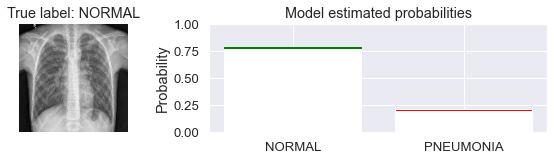

In [147]:
analyse_model_prediction(X_testFlat, Y_test, RFC, 3) 

## Deep Neural Networks

In order to deal with deeper architectures, the following steps are about to be followed before the classification:
1) In this experiments, we are going to use Train, Test and Validation set.<br>
2) Again we will find solution for the imbalance problem for both Train and Validation set, by using the over-sampling technique used before. As we've already mentioned, the deeper the architecture the more data we need and by using the aforementioned technique we achieve to raise the number of samples as well.<br>
3) During the Training there is a need for a representative validation set, but this subset contains only 16 images . So we will recreate our datasets by first concatenating train + val and after that applying a 20 % split to the new set.<br>
4) Also in order to achieve a better generalization ability of our model, we will use ImageDatagenerator for the train set for making our model more robust to unseen data. This technique will be used for modifying some image characteristics without deleting informations.


In [148]:
concat_train_val_df = pd.concat([train_df, val_df], ignore_index=True) #concatenation of the two subsets

In [150]:
train_set, val_set = train_test_split(concat_train_val_df, test_size=0.2) #splitting

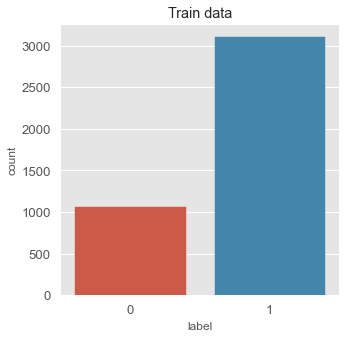

In [151]:
plt.figure(figsize=(5,5))
plt.style.use('ggplot')

plt.subplot(1,1,1)
sns.countplot(train_set['label'])
plt.title('Train data')
plt.show()

In [152]:
X_train, y_train = compose_dataset(train_set)
X_val, y_val = compose_dataset(val_set)

In [153]:
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]    # reshape the data sets
X_valShape = X_val.shape[1]*X_val.shape[2]*X_val.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_valFlat = X_val.reshape(X_val.shape[0], X_valShape)
Y_train = y_train
Y_val = y_val

In [154]:
sm = SMOTE(random_state=42)                                      #oversampling

X_trainsm, Y_trainsm = sm.fit_resample(X_trainFlat, Y_train)
X_valsm, Y_valsm = sm.fit_resample(X_valFlat, Y_val)

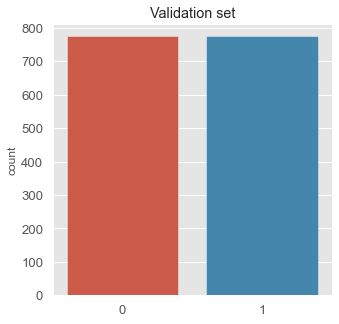

In [155]:
plt.figure(figsize=(5,5))
plt.style.use('ggplot')

plt.subplot(1,1,1)
sns.countplot(Y_valsm)
plt.title('Validation set')
plt.show()

In [158]:
X_train_reshaped1=X_trainsm.reshape(X_trainsm.shape[0],127,127) #reshapes
X_valsm_reshaped1=X_valsm.reshape(X_valsm.shape[0],127,127)

In [159]:
X_train_reshaped2=X_train_reshaped1.reshape(X_trainsm.shape[0],127,127,1)          #reshapes
X_valsm_reshaped2=X_valsm_reshaped1.reshape(X_valsm.shape[0],127,127,1)

In the next step we apply ImageDataGenerator to our data, in order to slightly modify (rotation, zoom, width etc) the train samples in each epoch during the training.

In [160]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train_reshaped2)



Although we have a binary classification problem and we could have 1D array target labels and a binary_crossentropy loss, we choose to use a 2D array for the target label and a categorical crossentropy. 

In [162]:
Y_trainsm = to_categorical(Y_trainsm)
y_test = to_categorical(y_test)
Y_valsm = to_categorical(Y_valsm)

As far as it concerns the architecture of the system, keras library is being used for designing a sequential model. The architecture starts with 2 convolutional layers of 8 filters and kernel size (7,7) after these layers a max pooling layer follows with pool size (3,3). Then, there are a repeating series of 2 convolutional layers followed by max pooling. Before proceeding to the dense layers we use a layer to flatten the inputs. After that, a dense layer with 128 nodes follows. The next layer is used for dropout (this also helps the model to generalize better). The next layer is the last one and is used for the prediction and because we use loss='categorical_crossentropy' and have two classes, therefore we are using two nodes and Softmax. In all the previous layers Relu was used as the activation function. In this Architecture, we use Adam as an optimizer and a learning rate of 0.00001. Furthermore, we employ early stopping for avoiding overfitting and a batch size = 4. Detailed information can be found in the next shell.

In [163]:
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(127, 127, 1)))
model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(lr=0.00001, decay=1e-5)
#optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callback = EarlyStopping(monitor='val_loss', patience=4)
history = model.fit(datagen.flow(X_train_reshaped2,Y_trainsm, batch_size=4), validation_data=(X_valsm_reshaped2, Y_valsm), epochs = 60, verbose = 1, callbacks=[callback])

Epoch 1/60
1555/1555 [==============================] - 111s 70ms/step - loss: 0.6810 - accuracy: 0.5685 - val_loss: 0.3757 - val_accuracy: 0.8786
Epoch 2/60
1555/1555 [==============================] - 119s 77ms/step - loss: 0.3956 - accuracy: 0.8274 - val_loss: 0.2608 - val_accuracy: 0.8960
Epoch 3/60
1555/1555 [==============================] - 121s 78ms/step - loss: 0.3047 - accuracy: 0.8696 - val_loss: 0.2412 - val_accuracy: 0.9057
Epoch 4/60
1555/1555 [==============================] - 121s 77ms/step - loss: 0.2787 - accuracy: 0.8853 - val_loss: 0.2107 - val_accuracy: 0.9270
Epoch 5/60
1555/1555 [==============================] - 120s 77ms/step - loss: 0.2607 - accuracy: 0.8936 - val_loss: 0.2602 - val_accuracy: 0.8921
Epoch 6/60
1555/1555 [==============================] - 120s 77ms/step - loss: 0.2476 - accuracy: 0.9072 - val_loss: 0.2070 - val_accuracy: 0.9205
Epoch 7/60
1555/1555 [==============================] - 117s 75ms/step - loss: 0.2312 - accuracy: 0.9088 - val_loss: 0

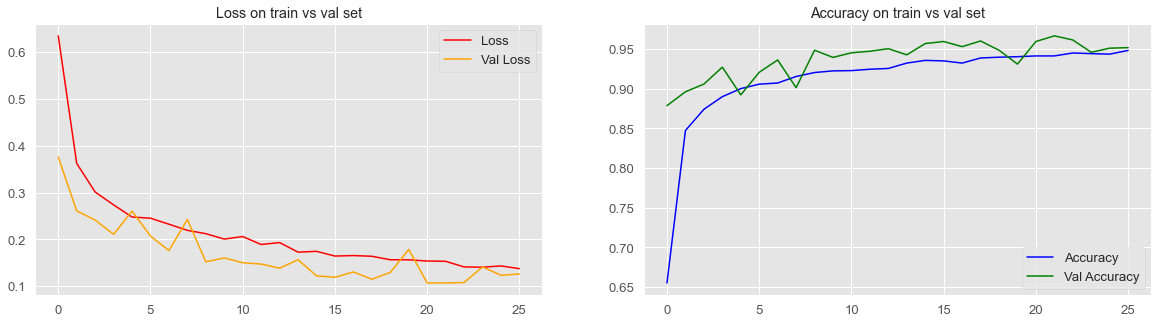

In [164]:
plt.figure(figsize=(20,5))
plt.style.use('ggplot')

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs val set')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs val set')
plt.legend(loc='best')

plt.show()

### Discussion of Learning curves

During training, we used Early stopping on validation accuracy with patience = 4 in order to avoid overfitting. In our case, the experiment stopped in the 26 epoch. From the two Figures, it is observed that both Loss and Val Loss have in general the same behaviour as the number of epochs arises until the point the Val loss starts to increase in value. The optimum point to stop the train is this point. In our case, we have the smallest Val loss in the 22 epoch. After this epoch, the Val loss starts to increase. Again the learning must be stopped here because otherwise ,we will lead our model to overfitting. If we continue the training probably the Loss curve will be reduced for a few more epochs, but the Val Loss will follow an upward course at the same time, which is not desirable.

The observations from the second Figure are exactly the same and can be explained accordingly. Again Accuracy and Val Accuracy have the same behaviour as the number of epochs arises until the point the Val Accuracy starts to decrease in value. Again the optimum Val Accuracy was found in the 22 epoch and after this point, its value was being decreased and this was a sign that the Learning process should be stopped.

In [165]:
y_test_hat = model.predict(X_test, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)
y_test = np.argmax(y_test, axis=1)

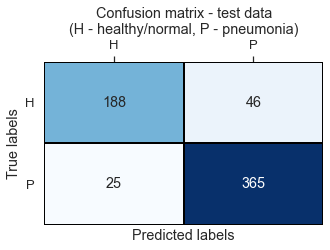

Classification report on test data
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       234
           1       0.89      0.94      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



In [166]:
# calculate confusion matrix & classification report
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['H', 'P'], yticklabels=['H', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('Confusion matrix - test data\n(H - healthy/normal, P - pneumonia)')
plt.show()

# print classification report
print('Classification report on test data')
print(clas_r)

### Discussion of the Resuls

By observing both the Confusion matrix and the Classification report on test data, one could easily see that this Deep Neural Network clearly outperforms the Classic Machine Learning approaches.
The comparison of the best Machine Learning approach (Random Forest Classifier) vs the DNN approach leads us to the following observations:

1) As far as it concerns the classification reports, the DNN approach had the best accuracy and best f1-scores for both categories.<br>
2) From the confusion matrix, the results show that the Normal category is predicted a lot better from the DNN approach, while Random Forest Classifier predicted correctly 20 samples more than the DNN approach. Of course, the difference is very small! 


### Inference module
In this section of the Project, one user is able to see for each image, that is part of the test set which was the predicted label from the model and which is actual. In this particular example, the first 17 images of the set are presented. As we see, the good performance reached from this model in the previous steps justifies the fact that most images are well predicted.

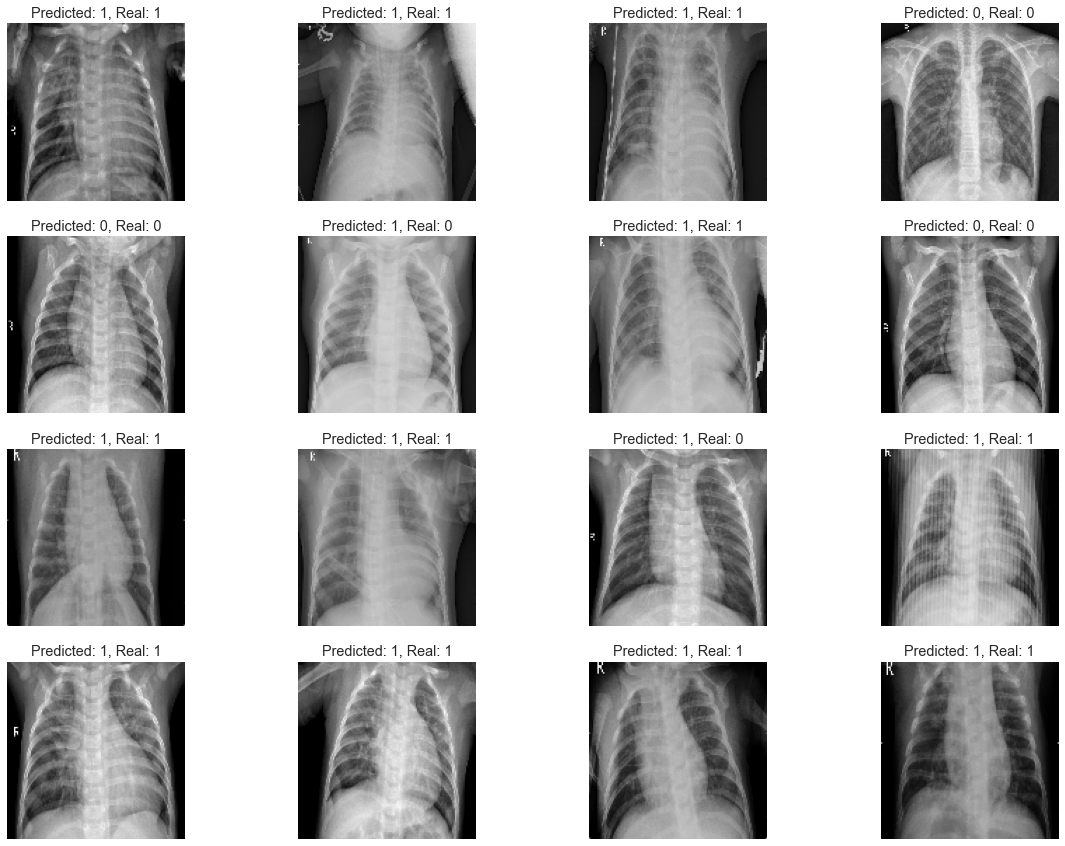

In [167]:
plt.figure(figsize=(20,15))
for i,x in enumerate(X_test[0:16]):
    plt.subplot(4,4,i+1)
    plt.imshow(x.reshape(127, 127), cmap='gray')
    plt.axis('off')
    plt.title('Predicted: {}, Real: {}'.format(y_test_hat[i], y_test[i]))  

## Transfer Learning approach (using VGG16 model as basemodel)

In this section, we design again a deep architecture that is based on Transfer Learning. As a base model a frozen VGG16 is being used and after that, a dense, a dropout and a prediction layer are being used for training and finally classify the images. 

In general, as far as it concerns the preprocessing steps, the same procedures are being held. The only difference is that we convert the images from Grayscales to RGB and resize them to 150*150 because the VGG16 model takes as input RGB images!



In [168]:
concat_train_val_df = pd.concat([train_df, val_df], ignore_index=True)

In [169]:
train_set, val_set = train_test_split(concat_train_val_df, test_size=0.2)

In [170]:
def convert_to_rgb_and_resize_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (150, 150))
    img = img/255.0
    img = np.reshape(img, (150,150,3))
    
    return img

def compose_dataset2(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(convert_to_rgb_and_resize_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

In [171]:
X_train, y_train = compose_dataset2(train_set)
X_test, y_test = compose_dataset2(test_df)
X_val, y_val = compose_dataset2(val_set)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (4185, 150, 150, 3), Labels shape: (4185,)
Test data shape: (624, 150, 150, 3), Labels shape: (624,)
Validation data shape: (1047, 150, 150, 3), Labels shape: (1047,)


In [172]:
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_valShape = X_val.shape[1]*X_val.shape[2]*X_val.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_valFlat = X_val.reshape(X_val.shape[0], X_valShape)
Y_train = y_train
Y_val = y_val

In [173]:
sm = SMOTE(random_state=42)

X_trainsm, Y_trainsm = sm.fit_resample(X_trainFlat, Y_train)
X_valsm, Y_valsm = sm.fit_resample(X_valFlat, Y_val)

In [176]:
X_train_reshaped1=X_trainsm.reshape(X_trainsm.shape[0],150,150,3)
X_valsm_reshaped1=X_valsm.reshape(X_valsm.shape[0],150,150,3)

In [178]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train_reshaped1)

In [179]:
Y_trainsm = to_categorical(Y_trainsm)
y_test = to_categorical(y_test)
Y_valsm = to_categorical(Y_valsm)

As far as it concerns the architecture of the system, keras library is being used for designing the model. In this experiment, we first use a VGG16 and keep it frozen. So at this part, we don't train VGG16, we simply use it for feature extraction. After that, on top of this architecture, we add three extra layers. In these three layers, the training is going to take place. The first layer is a Dense with 64 nodes and relu activation function and the second, is simply a 30 % Dropout and the last one is a dense with 2 nodes and a softmax which will be used for the predictions. Here a loss='categorical_crossentropy' is being used, Adam as an optimizer and a learning rate of 0.00001. Also, Early stopping is applied to the model for avoiding overfitting. Finally, a batch size=4 is used during the training. Detailed information can be found in the next shell.

As it is being shown we don't further finetune the model by unfreezing the VGG16 and start training the base model with a small learning rate. That may further improve the accuracy (at the cost of speed).



In [180]:
weight_path = './vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(weights = weight_path, include_top=False, input_shape=(150, 150, 3)) # Topless

# Add top layer
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
    
# Train top layer
for layer in base_model.layers:
    layer.trainable = False
model.compile(loss='categorical_crossentropy', 
                optimizer=keras.optimizers.Adam(lr=0.00001, decay=1e-5), 
                metrics=['accuracy'])
#callbacks_list = [keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1)]
model.summary()
# Fit model
callback = EarlyStopping(monitor='val_loss', patience=3)
#history = model.fit(X_train_reshaped1,Y_trainsm,batch_size=4, epochs=60, validation_data=(X_valsm_reshaped1 , Y_valsm), verbose=1, callbacks=[callback])
history = model.fit(datagen.flow(X_train_reshaped1,Y_trainsm, batch_size=4), validation_data=(X_valsm_reshaped1, Y_valsm), epochs = 60, verbose = 1, callbacks=[callback])




Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

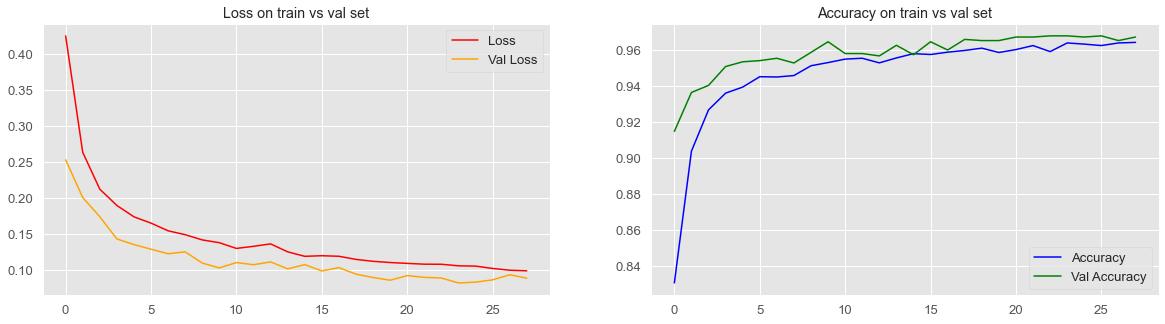

In [181]:
plt.figure(figsize=(20,5))
plt.style.use('ggplot')

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs val set')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs val set')
plt.legend(loc='best')

plt.show()

### Discussion of Learning curves

During training, we used Early stopping on validation accuracy with patience = 3 in order to avoid overfitting. In our case, the experiment stopped in the 28 epoch. From the two Figures, it is observed that both Loss and Val Loss have in general the same behaviour as the number of epochs arises until the point the Val loss starts to increase in value. In our case, we have the smallest Val loss in the 24 epoch. After this epoch, the Val loss starts to increase. 

The observations from the second Figure are exactly the same and can be explained in a similar way. Again Accuracy and Val Accuracy have the same behaviour as the number of epochs arises until the point the Val Accuracy starts to decrease in value. Again the optimum Val Accuracy was found in the 24 epoch and after this point, its value was being decreased and this was a sign that the Learning process should be stopped.



In [182]:
y_test_hat = model.predict(X_test, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)
y_test = np.argmax(y_test, axis=1)

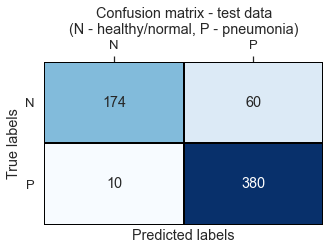

Classification report on test data
              precision    recall  f1-score   support

           0       0.95      0.74      0.83       234
           1       0.86      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.86      0.87       624
weighted avg       0.89      0.89      0.88       624



In [183]:
#calculate confusion matrix & classification report
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
plt.style.use('ggplot')
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['N', 'P'], yticklabels=['N', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('Confusion matrix - test data\n(N - healthy/normal, P - pneumonia)')
plt.show()

# print classification report
print('Classification report on test data')
print(clas_r)

### Discussion of the Resuls

By observing both the Confusion matrix and the Classification report on test data, one could see that the Transfer Learning approach achieves similar performance with the previous Deep Neural Network, while clearly outperforms the Classic Machine Learning approaches.
The comparison of Transfer Learning approach vs the previous DNN approach leads us to the following observations:

1) As far as it concerns the classification reports, the DNN approach has the best precision in the Pneumonia class, the best recall in the Normal class, the best f1 score in the Normal Class. On the other hand, the Transfer Learning approach has the best precision in the Normal class, the best recall in the Pneumonia class, the best f1 score in the Pneumonia Class. Finally, both methods reach the same accuracy score!<br>
2) From the confusion matrix, the results show that the Normal category is predicted better from the DNN approach, while the Pneumonia category is predicted better from the Transfer Learning approach!

Considering the above, as we've already mentioned, both methods perform equally good!

### Inference module
In this section of the Project, one user is able to see for each image, that is part of the test set which was the predicted label from the model and which is actual. In this particular example, the first 17 images of the set are presented. As we see, the good performance reached from the Transfer Learning approach in the previous steps justifies the fact that most images are well predicted.

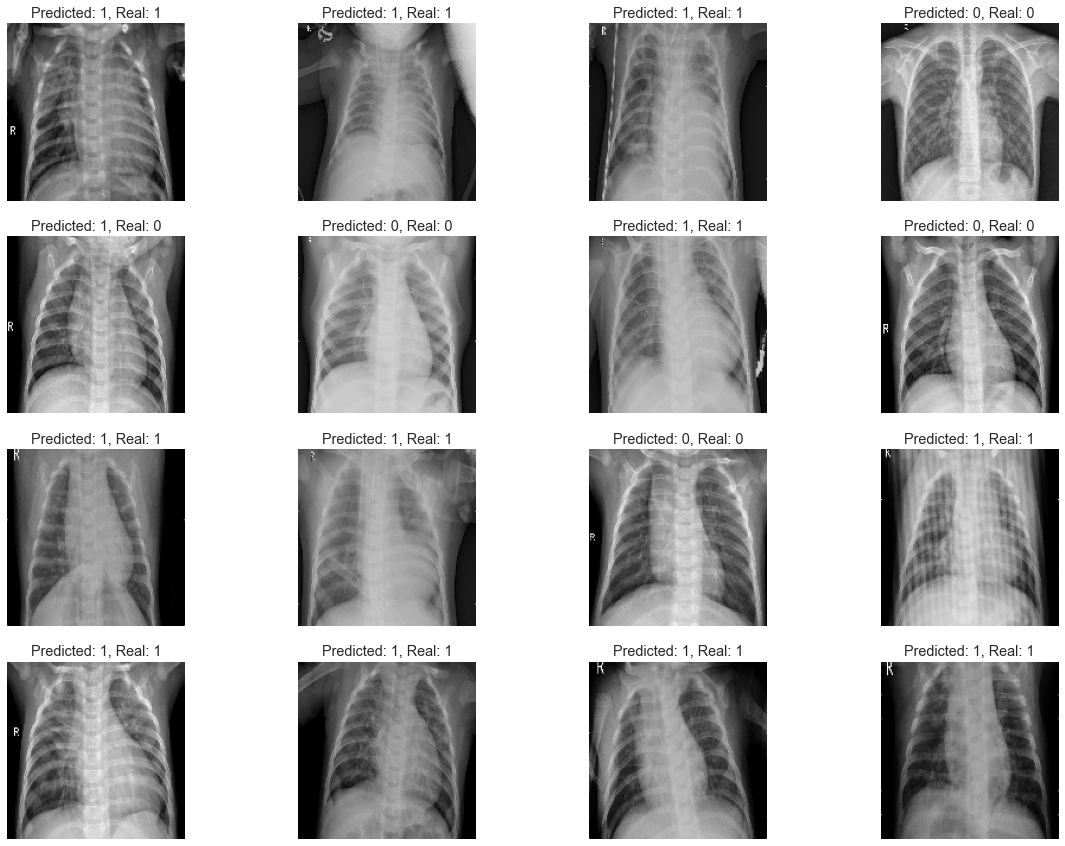

In [184]:
plt.figure(figsize=(20,15))
for i,x in enumerate(X_test[0:16]):
    
    plt.subplot(4,4,i+1)
    plt.imshow(x, cmap='gray')
    plt.axis('off')
    plt.title('Predicted: {}, Real: {}'.format(y_test_hat[i], y_test[i]))  

## Conclusions 

To conclude, the main focus of this project relied on detecting pneumonia in chest X-ray images, which is undoubtedly a classification problem. In order to achieve this task, first of all, exploratory data analysis was held. The next stage was the preprocessing and the final was the classification of the images. From this specific problem, we show that deeper architectures performed better than the Classic Machine Learning approaches. Finally, if we had to choose the best method, we would say that the DNN architecture that was designed from scratch is prefered from the Transfer Learning approach, because the Training in the latter method was a lot slower and the performances were similar.



